# Geographical clustering of 311-data

This document outlines the use of three clustering algorithms to organize 311 requests by geographical location and density. 

## Data organization and software tools

Clustering code is implemented in Python 3.74. Data is loaded into dataframes and subset in `pandas`. Plots are created in `seaborn` and `matplotlib`. Additional numerical operations are done using `numpy`.

Clustering operations for K-Means and DBSCAN are implemented using the `scikit-learn` library. HDBSCAN is implemented in the `hdbscan` library. Links for these packages are provided at the end of this document.

## Initial data operations

We first import necessary libraries for global data handling tasks and open data in `pandas`. We also set a number of global variables that dictate the behavior of the run, including the location of the data file, the type of 311 request we are interested in clustering, how far back we wish for the clustering operation to reach, and how many clusters we wish to evaluate when considering the optimal number of clusters we needed to fit the data (for elbow plot).

After setting global variables we subset the data to be of manageable size and to better capture recent temporal trends.

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import math

# Global variables and run flags
data311 = '~/Downloads/311data.tsv' # dataset | script assumes data is in same directory as notebook
INTEREST = 'Graffiti Removal' # variable of interest
SUBSET = 20000 # take last SUBSET rows of data by date
SWEEPMAX=25 # Number of clusters to evaluate for elbow plot

# Load data into data frame
data = pd.read_csv(data311, sep='\t')

# Optional data subsetting (takes most recent reports)
data = data[np.logical_not(np.isnan(data['Longitude']))]

if len(INTEREST) > 0:
    varFilter = data['RequestType'] == INTEREST
    data = data[varFilter]

if SUBSET:
    data = data[-SUBSET:]


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## K-Means Clustering

K-means clustering involves spatial clustering of points, but does not take into account density when distinguishing individual clusters. The resulting centroids delineate the centers of mass of the clusters that are assigned.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


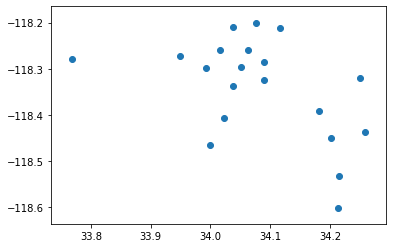

In [3]:
# Clustering definitions
from sklearn.cluster import KMeans

X=data.as_matrix(columns=['Latitude','Longitude'])

km = KMeans(n_clusters=20, 
    init='random',
    n_init=10,
    max_iter=300,
    tol=1e-04,
    random_state=0)

y_km = km.fit_predict(X)

# Get centroids
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1])
plt.show()

## Assessing Model Fit

In order to discern the ideal number of clusters, we can train a model at various specified cluster thresholds and assess sum of squared distance from the centroid to which they have been assigned (reported as inertia).

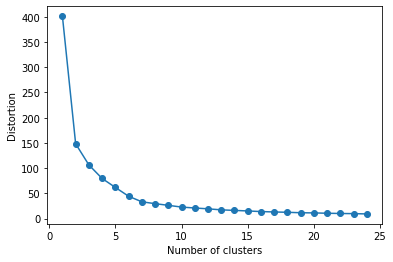

In [4]:
distortions = []
for i in range(1, SWEEPMAX):
    km = KMeans(
        n_clusters=i,
        init='random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1, SWEEPMAX), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

plt.show()

We can assess from this plot that our ideal number of clusters is in the 5-10 cluster range.

## DBSCAN Clustering

DBSCAN takes into account density when creating clusters of data. Points with many nearby neighbors are inferred to be more likely to belong to a shared cluster. 

In [6]:
from sklearn.cluster import DBSCAN

dbsc = DBSCAN(eps = .005, min_samples = 15).fit(X)

# We append these labels to data points in the original data subset
data['dbsc'] = dbsc.labels_

We are able to display the resulting clusters. Clusters labeled -1 are data points determined to be "noisy" or difficult to determine a cluster to which they should be assigned. The largest clusters tend to be "leftover" categories with little geographic similarity.

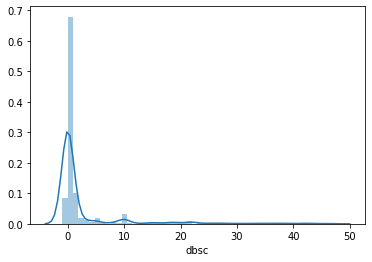

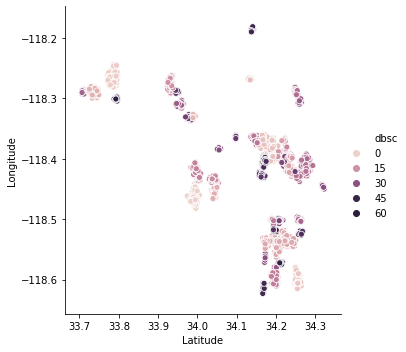

In [7]:
sns.distplot(data['dbsc'])
sns.relplot(x='Latitude', y='Longitude', hue='dbsc', data=data[data['dbsc'] > 0])
plt.show()

### Issues
1. Implement cluster fitting plot
2. Implement shapefile plotting

## HDBSCAN

HDBSCAN is a hierarchical method of clustering built on DBSCAN. It features additional sensitivity to density of data points. It allows specification of the minimum number of points that are required to be in each cluster. Again the points that are close to zero represent either diffuse clusters or clusters that were unable to be assigned.

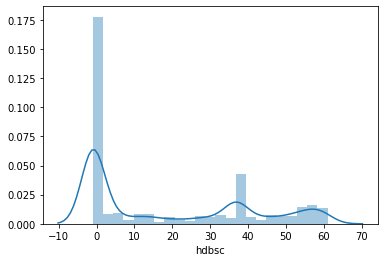

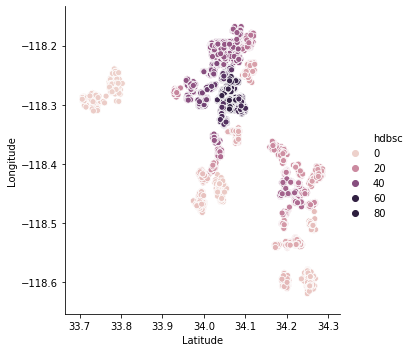

In [8]:
import hdbscan
hdbsc = hdbscan.HDBSCAN(min_cluster_size=40) 
# FEATURE: Need way to set ideal level of minimum cluster size (otherwise thousands of clusters)
hdbsc.fit(X)
data['hdbsc'] = hdbsc.labels_

sns.distplot(data['hdbsc'])
sns.relplot(x='Latitude', y='Longitude', hue='hdbsc', data=data[data['hdbsc'] > 0])
plt.show()